本章节将展示将一维数据绘图和二维地理数据绘制在一张Figure的代码(本质上没有不同),
并展示子图非常规(网格)布局代码及需要注意的小问题.

所用的一维数据为前面用过的1951-2020的D(-1)JF的Nino34和MAM的热带印度洋海温指数(40–110°E,20°S–20°N);
而二维数据为上面两个指数与JJA的降水场的相关系数图.

In [1]:
# 导入必要的库
import numpy as np
import xarray as xr
import proplot as plot
from cartopy.util import add_cyclic_point # 避免图形中出现空白线
from scipy.stats import t # 用于计算临界相关系数

In [2]:
# 编写函数取出数据
def get_4seasons_data_5120(path, var, lat_range,
                           level=None):
    """
    path: 文件路径
    var: 变量名
    lat_range: 纬度范围(例如:np.arange(60, -62, -2))
    level: 抽取的层数(例如:850), 可能用于读取风场数据

    Return:
    lat: 纬度
    lon: 经度
    array_4seasons_5120: 变量的数组(year, seasons, lat, lon)
    """

    data = xr.open_dataset(path)
    if level is None:
        data = data.sel(lat=lat_range, time=slice('1950-01-01', '2020-12-31'))
    else:
        data = data.sel(lat=lat_range, level=level, time=slice('1950-01-01', '2020-12-31'))
    lat = data.lat.data
    lon = data.lon.data
    array = data[var].data

    array_4seasons_5120 = np.empty((70, 4, len(lat), len(lon)))
    for i in range(70):
        for season in range(4):
            index = 11 + 12*i + 3*season
            array_4seasons_5120[i, season] = array[index:index+3].mean(axis=0)

    # !!!扣除线性趋势(务必注意,除非是研究长期趋势的问题,否则都需要扣除长期线性趋势)
    for season in range(4):
        for i in range(len(lat)):
            for j in range(len(lon)):
                if (np.isnan(array_4seasons_5120[:, season, i, j].sum())):  # 排掉陆地值点
                    array_4seasons_5120[:, season, i, j] = np.nan
                else:
                    x = np.arange(1, 71, 1)
                    z = np.polyfit(x,array_4seasons_5120[:, season, i, j], 1) #用线性回归拟合出长期线性趋势
                    y = np.polyval(z, x)

                    array_4seasons_5120[:, season, i, j] = array_4seasons_5120[:, season, i, j] - y

    return lat, lon, array_4seasons_5120

def cal_area_index(array_yearly, lat, lon, lat_range, lon_range):
    """
    array_yearly: 需要求解区域均值变量的场数据(year, lat, lon)
    lat: array_yearly对应的纬度(1d array)
    lon: array_yearly对应的经度(1d array)
    lat_range: 纬度范围(list)
    lon_range: 经度范围(list)

    Return:
    area_index: 指数序列(1d array)

    Note: 此函数处理不了跨域lon=360的情况
    """

    # 得到纬度和经度的索引
    lat_min = min(lat_range)
    lat_max = max(lat_range)
    lat_index = (lat>=lat_min) & (lat<=lat_max)

    lon_min = min(lon_range)
    lon_max = max(lon_range)
    lon_index = (lon>=lon_min) & (lon<=lon_max)

    # 得到区域均值
    temp = array_yearly[:, lat_index]
    temp = temp[:, :, lon_index]
    area_index = np.nanmean(np.nanmean(temp, axis=-1), axis=-1)

    return area_index

In [3]:
# 获取数据
lat_sst, lon_sst, sst_4seasons_5120 = get_4seasons_data_5120(r'data/sst.mnmean_new.nc', 'sst',
                                                            np.arange(60, -62, -2) # 等价于slice(60, -60)
                                                            )
lat_precip, lon_precip, pre_4seasons_5120 = get_4seasons_data_5120(r'data/NOAA_Precipitation_Reconstruction.precip.mon.anom.nc', 'precip',
                                                                   slice(60, -60))

# -----------------------------------------------------------------------

Nino34_DJF_5120 = cal_area_index(sst_4seasons_5120[:, 0],
                                 lat_sst, lon_sst, [-6, 6], [190, 240])
TIOB_MAM_5120 = cal_area_index(sst_4seasons_5120[:, 1],
                               lat_sst, lon_sst, [-20, 20], [40, 110])

In [4]:
# 求解相关系数场的函数
def get_corrmap(index, lat, lon, array_5120):
    """
    input:
    index: 指数序列(1d array)
    lat: array_5120对应的纬度(1d array)
    lon: array_5120对应的经度(1d array)
    array_5120: 场数据(year, lat, lon)

    Return:
    corrmap: 相关系数场(lat, lon)
    """

    corrmap = np.empty((len(lat), len(lon)))
    for i in range(len(lat)):
        for j in range(len(lon)):
            if (np.isnan(array_5120[:, i, j].sum())):  # 排掉陆地值点
                corrmap[i, j] = np.nan
            else:
                corr = np.corrcoef(index, array_5120[:, i, j])
                corrmap[i, j] = corr[0, 1]

    return corrmap

In [5]:
pre_JJA_5120 = pre_4seasons_5120[:, 2]

corrmap_pre_Nino34 = get_corrmap(Nino34_DJF_5120, lat_precip, lon_precip, pre_JJA_5120)
corrmap_pre_TIOB = get_corrmap(TIOB_MAM_5120, lat_precip, lon_precip, pre_JJA_5120)

In [6]:
# 计算70年的临界相关系数(看不懂可以跳过)
n = 70
a = 0.1 # 0.1显著性水平
t_half_a = t.isf(a / 2, n - 2)
t_half_a = round(t_half_a, 5)
r_base = t_half_a / ((t_half_a ** 2) + n - 2) ** 0.5
r_base

0.19821036970041964

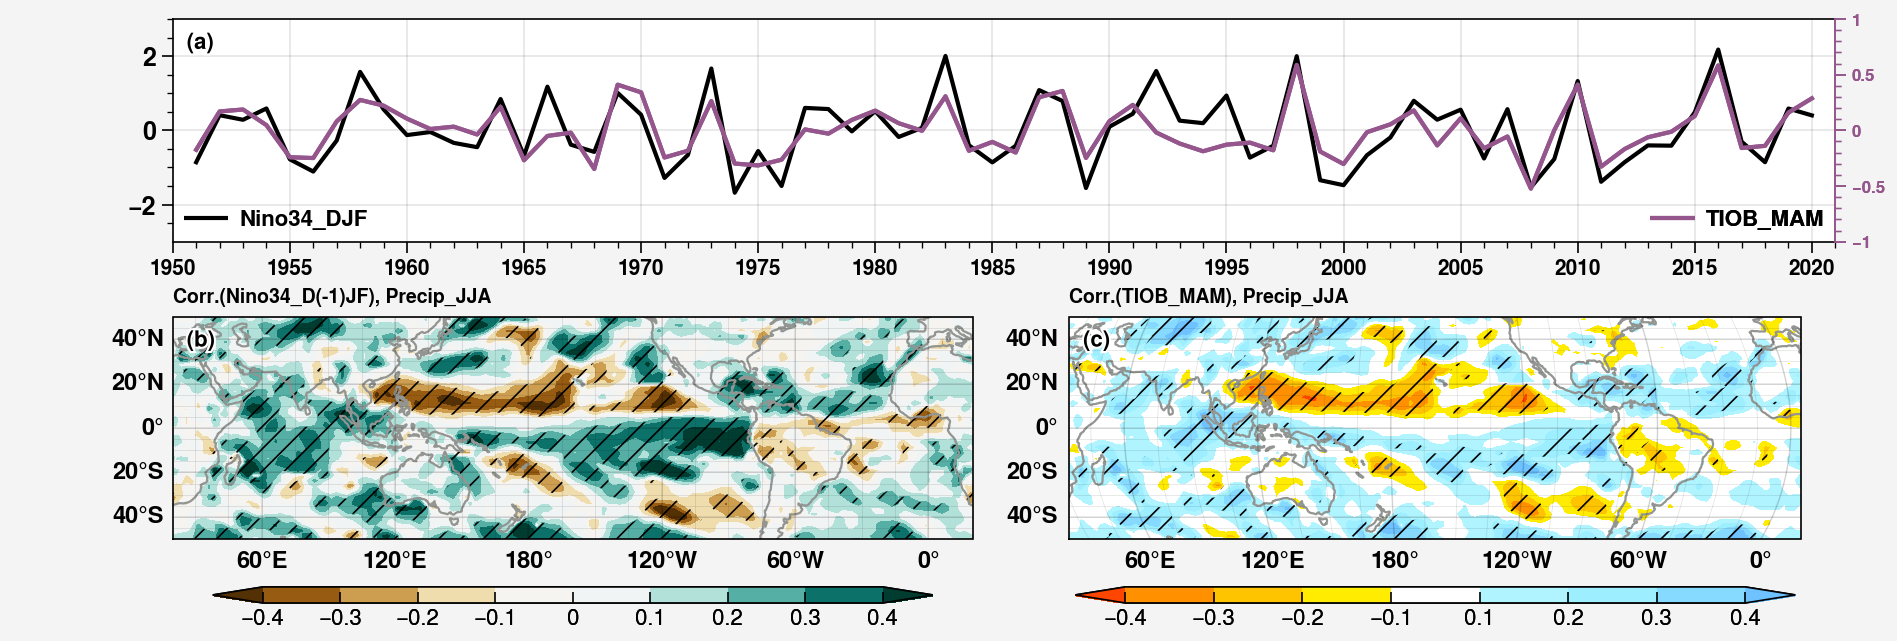

In [7]:
# 绘图
# 既绘制线图,也绘制相关系数图
# 采用特殊布局
subplot_array = [[1, 1], # 子图的布局,1表示第一幅子图,2表示第二幅子图... (4幅子图代表了不同的二维数据图样式)
                 [2, 3]] # 通过观察可以发现,这里是特殊布局(实际效果看最后的Figure)
plot.rc.reso = 'lo'  # 海岸线使用分辨率 'hi' 'med' 'lo'
proj1 = plot.Proj('cyl', lon_0=200)
proj2 = plot.Proj('eck3', lon_0=200) # 换一种投影
fig = plot.figure(hspace=3, wspace=2.5, # 利用hspace和wspace参数解决自由调整行间距和列间距 !!!(这么做可以巧妙地避免以往使用cartopy的时候出现默认间距过宽的问题)
                  refnum=2, refwidth=4) # 将子图的长宽参考点设置在不能自由改变长宽比例的地理二维图中,巧妙避免空白过多的问题(官方文档的说明))
                                        # 之所以要这么搞是因为根据cartopy的强制规定,地理图的长宽比例不能随便更改,目的是为了保持正确的投影
axs = fig.subplots(subplot_array, proj=[None, # 线图无需投影
                                        proj1, proj2])

axs[0].format( # 规定第一幅子图的format
           abc='(a)', # 规定子图的abc标签的样式
           abcloc='ul', # 规定子图的abc标签的位置 ul表示左上角(upper left)
           abcsize=8, # 子图的abc标签大小
           ylim=(-3, 3), # y轴范围
           xlim=(1950, 2021), # x轴范围
           ylabel='SST Indexes', # y轴标签
           ylabelsize=8, # y轴标签字体大小
           ylabelweight='heavy', # y轴标签字体粗细
           xticks=5,  # x轴刻度数量
           xtickminor=True, # x轴是否显示次刻度
           xticklabelsize=7.5, # x轴刻度字体大小
           ticklabelweight='bold', # xy轴刻度字体粗细
           titlesize=8,  # 子图标题字体大小
           titleweight='bold' # 子图标题字体粗细
           )
axs[1:].format( # 规定第二,三幅子图的format
    abc='(a)', abcloc='ul', abcsize=8,
    gridlabelsize=8.5, # 坐标轴标签字体大小
    gridlabelweight='heavy', # 坐标轴标签字体粗细
    labels=True, # 是否显示坐标轴标签
    lonlines=60, # 经度标签间隔
    latlines=20, # 纬度标签间隔
    latlim=(-50.1, 50.1), # 图的纬度范围
    gridminor=True,  # 是否显示次级网格
    coast=True,   # 是否显示海岸线
    coastlinewidth=0.8, # 海岸线宽度
    coastcolor='gray', # 海岸线颜色
    coastzorder=0, # 海岸线图层(越小越先画)
    titlesize=7,  # 标题字体大小
    titleweight='heavy' # 标题字体粗细
)
cmap = plot.Colormap('BrBG') # 规定colormap

# 绘制子图1(从前面搬过来的代码)
axs[0].plot(np.arange(1951, 2021, 1), Nino34_DJF_5120,
            color='k', # 线的颜色
            linewidth=1.5, # 线的宽度
            label='Nino34_DJF') # Nino34指数正常绘制
ox = axs[0].alty(color='purple',
                 ylim=(-1, 1), # 新y轴的范围
                 ticklabelweight='bold', # xy轴刻度字体粗细(需要重新设置)
                 ticklabelsize=6
                 )
ox.plot(np.arange(1951, 2021, 1), TIOB_MAM_5120,
        color='purple', # 线的颜色
        linewidth=1.5, # 线的宽度
        label='TIOB_MAM')
axs[0].legend(loc='ll', # 图例的位置 ll表示左下角(lower left)
              fontweight='heavy', # 字体粗细
              prop = {'size':8}, # 字体大小
              framealpha=0 # 图例边框的透明度
              )
ox.legend(loc='lr',
          fontweight='heavy', # 字体粗细
          prop = {'size':8}, # 字体大小
          framealpha=0 # 图例边框的透明度
          )

# 绘制子图2
axs[1].format(ltitle='Corr.(Nino34_D(-1)JF), Precip_JJA')
cycle_corrmapPre, cycle_lonPre = add_cyclic_point(corrmap_pre_Nino34,
                                                  coord=lon_precip)  # 避免出现白线(本质问题是0°和360°经线是同一条)
m = axs[1].contourf(cycle_lonPre, lat_precip, cycle_corrmapPre,
                    cmap=cmap,
                    levels=np.arange(-0.4, 0.41, 0.1), # 等值线间隔
                    cmap_kw={'cut': -0.1}, # 将-0.1~0.1之间colormap颜色裁剪成白色
                    extend='both', # 扩展至两边(colorbar两头用箭头)
                    zorder=0, # 图层顺序(越小越先画,这里填色与海岸线是同一图层)
                    )
hatch = axs[1].contourf(cycle_lonPre, lat_precip, np.abs(cycle_corrmapPre),
                levels=[0, r_base, 1], cmap=cmap,
                hatches=[None, '///'], # 规定hatches来表示过检验的区域
                alpha=0, # 不要颜色(将透明度设置为全透明)
                zorder=0) # 其实也可以使用scatter完成打点, 因为hatches默认是黑色而且修改很烦
axs[1].colorbar(m, loc='b',
             width=0.08, # colorbar宽度
             length=0.9, # colorbar长度
             ticklabelsize=8, # colorbar刻度字体大小
             extendsize='2em', # 两边箭头的长度
             tickdir='in' # 刻度方向(in为内, out为外)
             )

# 绘制子图3(额外演示一下自定义colormap)
axs[2].format(ltitle='Corr.(TIOB_MAM), Precip_JJA')
cycle_corrmapPre, cycle_lonPre = add_cyclic_point(corrmap_pre_TIOB,
                                                  coord=lon_precip)  # 避免出现白线(本质问题是0°和360°经线是同一条)
m = axs[2].contourf(cycle_lonPre, lat_precip, cycle_corrmapPre,
                    levels=[-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4], # 等值线间隔, 这里是自定义
                    colors=['#ff4600', '#ff9100', '#ffc400', '#ffec00', # 负值的颜色,越红越干
                            '#ffffff', # 绝对值小于0.1隐去的颜色(白色)
                            '#b0f4ff', '#9deeff', '#86d9ff', '#6dc2ff', # 正值的颜色,越蓝越湿
                            ],
                    extend='both', # 扩展至两边(colorbar两头用箭头)
                    zorder=0, # 图层顺序(越小越先画,这里填色与海岸线是同一图层)
                    )
hatch = axs[2].contourf(cycle_lonPre, lat_precip, np.abs(cycle_corrmapPre),
                levels=[0, r_base, 1], cmap=cmap,
                hatches=[None, '///'], # 规定hatches来表示过检验的区域
                alpha=0, # 不要颜色(将透明度设置为全透明)
                zorder=0) # 其实也可以使用scatter完成打点, 因为hatches默认是黑色而且修改很烦
axs[2].colorbar(m, loc='b',
             width=0.08, # colorbar宽度
             length=0.9, # colorbar长度
             ticklabelsize=8, # colorbar刻度字体大小
             extendsize='2em', # 两边箭头的长度
             tickdir='in' # 刻度方向(in为内, out为外)
             )
